# Deep Supervised Hashing

In this tutorial we will train a neural network to extract hash codes for images. As before, two different evaluation setups will be used:

1. **in-domain evaluation**, where test (unknown) data from the *same* domain will be used for the evalutation,
2. **out-of-domain evaluation**, where data from a *different* domain will be used for the evaluation.


Do the regular stuff (load the data, split and normalize)!

In [1]:
import keras
from keras.datasets import cifar10
import numpy as np

(x_train, y_train), (x_test, y_test) = cifar10.load_data()


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Split the dataset into in-domain and out-of-domain data
train_idx_out = np.logical_or(y_train==0, np.logical_or(y_train==1, np.logical_or(y_train==2, y_train==3)))[:, 0]
test_idx_out = np.logical_or(y_test==0, np.logical_or(y_test==1,  np.logical_or(y_test==2, y_test==3)))[:, 0]

x_train_in, y_train_in = x_train[np.logical_not(train_idx_out)], y_train[np.logical_not(train_idx_out)]
x_test_in, y_test_in = x_test[np.logical_not(test_idx_out)], y_test[np.logical_not(test_idx_out)]

# Out-of-domain
x_train_out, y_train_out = x_train[train_idx_out], y_train[train_idx_out]
x_test_out, y_test_out = x_test[test_idx_out], y_test[test_idx_out]

print("Train data (in): ", x_train_in.shape, y_train_in.shape)
print("Test data (in): ",  x_test_in.shape, y_test_in.shape)
print("Train data (out): ", x_train_out.shape, y_train_out.shape)
print("Test data (out): ", x_test_out.shape, y_test_out.shape)


Train data (in):  (30000, 32, 32, 3) (30000, 1)
Test data (in):  (6000, 32, 32, 3) (6000, 1)
Train data (out):  (20000, 32, 32, 3) (20000, 1)
Test data (out):  (4000, 32, 32, 3) (4000, 1)


In [3]:
# Normalize the data
x_train_out = x_train_out/255.0
x_test_out = x_test_out/255.0
x_train_in = x_train_in/255.0
x_test_in = x_test_in/255.0

In [4]:
y_train_out = keras.utils.to_categorical(y_train_out, 10)
y_test_out = keras.utils.to_categorical(y_test_out, 10)
y_train_in = keras.utils.to_categorical(y_train_in, 10)
y_test_in = keras.utils.to_categorical(y_test_in, 10)

Define the neural network! Also, note that the size of the output layer of the neural network controls the size of the learned has codes (in this tutorial hash codes of 32 bits are used).

In [5]:
from keras.models import Sequential
import keras.optimizers
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))

# Extract 32-bit hash codes
model.add(Dense(32))


In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

Next, we have to define a simple pairwise loss function. Note that we also impose a hashing constraint to ensure that the sign function can be readily applied to obtain final the hash codes. This function was proposed in "Deep Supervised Hashing for Fast Image Retrieval", CVPR 2016 by Haomiao Liu, Ruiping Wang, Shiguang Shan, and Xilin Chen.

In [7]:
import tensorflow as tf
import keras.backend as K

def hashing_loss(y_true, y_pred, m, alpha):
    """
    Implements the loss described in the following paper:
    https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Liu_Deep_Supervised_Hashing_CVPR_2016_paper.pdf
    
    """

    # Compute the pairwise distances      
    distances = tf.reduce_sum(tf.squared_difference(tf.expand_dims(y_pred, 1), tf.expand_dims(y_pred, 0)), 2)
    # Compute the ground truth similarity matrix
    targets = tf.matmul(y_true, tf.transpose(y_true))

    hashing_regularizer = tf.reduce_sum(tf.abs((tf.abs(y_pred) - 1)))

    supervised_loss = tf.reduce_sum(0.5*targets*distances + 0.5*(1-targets)*tf.maximum(0*distances, m - distances))
    
    return supervised_loss + alpha * hashing_regularizer

In [8]:
# Set the hyper-parameters
# m set according to paper to 2 * number of bits
my_custom_loss = lambda x,y: hashing_loss(x, y, m=2*32, alpha=0.001)

# Compile the model
opt = keras.optimizers.adam(lr=0.001)
model.compile(loss=my_custom_loss, optimizer=opt)

We are now ready to fit our model!

In [9]:
model.fit(x_train_in, y_train_in, batch_size=128,  epochs=30,
              shuffle=True, verbose=1)

Epoch 1/30
30000/30000 [==============================] - 6s 201us/step - loss: 133293.9433
Epoch 2/30
30000/30000 [==============================] - 4s 143us/step - loss: 111630.8843
Epoch 3/30
30000/30000 [==============================] - 4s 138us/step - loss: 105922.5145
Epoch 4/30
30000/30000 [==============================] - 4s 131us/step - loss: 100921.5786
Epoch 5/30
30000/30000 [==============================] - 4s 137us/step - loss: 94779.5975
Epoch 6/30
30000/30000 [==============================] - 4s 132us/step - loss: 89632.8075
Epoch 7/30
30000/30000 [==============================] - 4s 133us/step - loss: 84829.8017
Epoch 8/30
30000/30000 [==============================] - 4s 133us/step - loss: 80809.3860
Epoch 9/30
30000/30000 [==============================] - 4s 135us/step - loss: 77095.3818
Epoch 10/30
30000/30000 [==============================] - 4s 135us/step - loss: 74142.5800
Epoch 11/30
30000/30000 [==============================] - 4s 135us/step - loss: 7131

Finally, evaluate the model! Note that we use the hamming distance to retrieval the relevant images from the database.


100%|██████████| 1/1 [00:00<00:00,  6.54it/s]


In-domain mAP:90.2954 
Out-of-domain mAP:49.4996 


Text(0.5,1,'out-of-domain precision-scope')

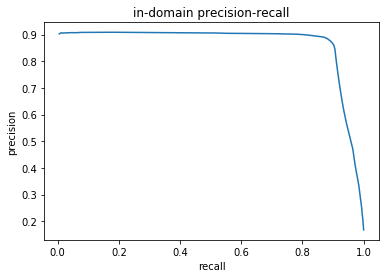

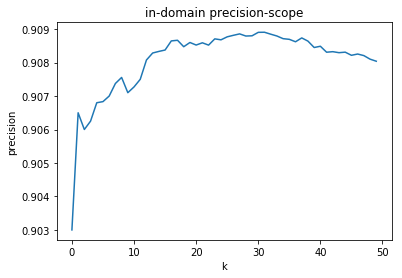

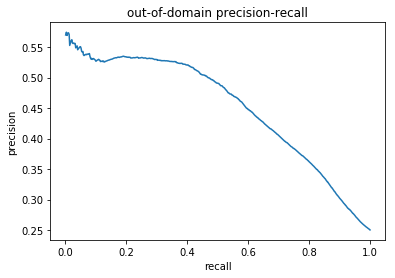

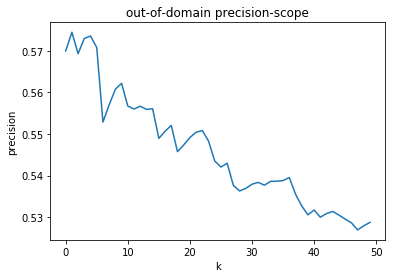

In [10]:
from evaluation import evaluate_database

import matplotlib.pyplot as plt
%matplotlib inline

for i in range(123, 127):
     plt.figure(i)
     plt.clf()


n_samples = 1000
feat_train_in = np.sign(model.predict(x_train_in[:n_samples]))
feat_test_in =  np.sign(model.predict(x_test_in[:n_samples]))
    
feat_train_out = np.sign(model.predict(x_train_out))
feat_test_out = np.sign(model.predict(x_test_out))
    
    
m_ap, precision, recall, precision_at_recall_levels, ap, hamming_2_prec = \
    evaluate_database(feat_train_in[:n_samples], np.argmax(y_train_in[:n_samples], axis=1),  
                      feat_test_in[:n_samples], np.argmax(y_test_in[:n_samples], axis=1), metric='hamming' )
    
print("In-domain mAP:%3.4f "%(100*m_ap))
plt.figure(123)
plt.plot(recall, precision)

plt.figure(124)
plt.plot(np.arange(50), precision[:50], )
    
m_ap, precision, recall, precision_at_recall_levels, ap, hamming_2_prec = \
    evaluate_database(feat_train_out[:n_samples], np.argmax(y_train_out[:n_samples], axis=1),  
                     feat_test_out[:n_samples], np.argmax(y_test_out[:n_samples], axis=1), metric='hamming' )
    
print("Out-of-domain mAP:%3.4f "%(100*m_ap))
plt.figure(125)
plt.plot(recall, precision)

plt.figure(126)
plt.plot(np.arange(50), precision[:50], )

# Make the plots a bit prettier

plt.figure(123)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('in-domain precision-recall')

plt.figure(124)
plt.xlabel('k')
plt.ylabel('precision')
plt.title('in-domain precision-scope')

plt.figure(125)
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('out-of-domain precision-recall')

plt.figure(126)
plt.xlabel('k')
plt.ylabel('precision')
plt.title('out-of-domain precision-scope')
